#### Импортируем библиотеки:

In [ ]:
# Принудительно отключим предупреждения системы
import warnings
warnings.simplefilter(action = 'ignore', category = Warning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.multioutput import MultiOutputClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import hamming_loss, jaccard_score
from sklearn.metrics import precision_score, recall_score, f1_score

#### Функции для решения:

In [ ]:
def preprocessing_for_df(df):

    # Удаление строк с дубликатами и строк, в которых все пропущенные значения 
    df = df.drop_duplicates().dropna(how='all').reset_index(drop=True).set_index('sku_in_code')

    return df

In [ ]:
def plot_target_columns(df):

    sns.set_style("whitegrid")

    plt.figure(figsize=(15, 4))

    # График для 'Product_category'
    plt.subplot(1, 2, 1)
    sns.countplot(x='Product_category', data=df, palette='pastel')  
    plt.title('Distribution of Product Categories')
    plt.xticks(rotation=45)

    # График для 'Pack_type'
    plt.subplot(1, 2, 2)
    sns.countplot(x='Pack_type', data=df, palette='pastel')
    plt.title('Distribution of Pack Types')
    plt.xticks(rotation=45) 

    plt.tight_layout()
    plt.show()

In [ ]:
def learning_first(df):

    def quality_control(y_pred, y1_test, y2_test):

        """
        - Accuracy (Точность): Доля правильно предсказанных меток по всем образцам данных. 
        - Hamming Loss (Потери Хэмминга): Среднее значение доли неверно предсказанных меток для всех образцов данных. 
        - Jaccard Similarity Score (Jaccard Index) (Коэффициент Жаккара): Мера сходства между двумя множествами меток, рассчитываемая как отношение 
        пересечения множества предсказанных меток к их объединению. 
        - Precision (Точность): Доля верно предсказанных меток класса к общему количеству предсказанных меток этого класса. 
        - Recall (Полнота): Доля верно предсказанных меток класса к общему количеству истинных меток этого класса. 
        - F1 Score: Среднее гармоническое точности и полноты. Это объединенная метрика, которая учитывает как точность, так и полноту предсказаний модели.
        """
        
        # Разделение предсказанных меток на два массива
        y1_pred = y_pred[:, 0]  # Первый столбец предсказаний
        y2_pred = y_pred[:, 1]  # Второй столбец предсказаний

        # Вычисление метрик для первого целевого признака
        accuracy_y1 = accuracy_score(y1_test, y1_pred, normalize=True)
        hamming_loss_y1 = hamming_loss(y1_test, y1_pred)
        jaccard_score_y1 = jaccard_score(y1_test, y1_pred, average='weighted')
        precision_y1 = precision_score(y1_test, y1_pred, average='weighted')
        recall_y1 = recall_score(y1_test, y1_pred, average='weighted')
        f1_score_y1 = f1_score(y1_test, y1_pred, average='weighted')

        # Вычисление метрик для второго целевого признака
        accuracy_y2 = accuracy_score(y2_test, y2_pred, normalize=True)
        hamming_loss_y2 = hamming_loss(y2_test, y2_pred)
        jaccard_score_y2 = jaccard_score(y2_test, y2_pred, average='weighted')
        precision_y2 = precision_score(y2_test, y2_pred, average='weighted')
        recall_y2 = recall_score(y2_test, y2_pred, average='weighted')
        f1_score_y2 = f1_score(y2_test, y2_pred, average='weighted')

        # Среднее значение метрик
        average_accuracy = (accuracy_y1 + accuracy_y2) / 2
        average_hamming_loss = (hamming_loss_y1 + hamming_loss_y2) / 2
        average_jaccard_score = (jaccard_score_y1 + jaccard_score_y2) / 2
        average_precision = (precision_y1 + precision_y2) / 2
        average_recall = (recall_y1 + recall_y2) / 2
        average_f1_score = (f1_score_y1 + f1_score_y2) / 2

        print("Accuracy:", average_accuracy)
        print("Hamming Loss:", average_hamming_loss)
        print("Jaccard Similarity Score (Jaccard Index):", average_jaccard_score)
        print("Precision:", average_precision)
        print("Recall:", average_recall)
        print("F1 Score:", average_f1_score)

    X = df[['manufacturer', 'brand', 'sku']]
    y1 = df['Product_category']
    y2 = df['Pack_type']

    # Предобработка категориальных признаков
    X_train_encoded = pd.get_dummies(X)

    # Разделение данных на тренировочный и тестовый наборы
    X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X_train_encoded, y1, y2, test_size=0.3, random_state=42)

    # Создание и обучение модели CatBoostClassifier с использованием MultiOutputClassifier
    model = MultiOutputClassifier(CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, loss_function='MultiClass'))
    model.fit(X_train, pd.concat([y1_train, y2_train], axis=1), verbose=0)

    # Получение предсказанных значений для тестового набора данных
    y_pred = model.predict(X_test)
    y_pred = y_pred[0]  # Преобразовать размерность

    return quality_control(y_pred, y1_test, y2_test)

#### Решение:

In [9]:
df_file_1 = pd.read_csv('~/Applications/Test-task-solution-2/Test/file_1.csv', low_memory=False, sep=';')
df_file_2 = pd.read_csv('~/Applications/Test-task-solution-2/Test/file_2.csv', low_memory=False, sep=';')

print('dimension file_1: ', df_file_1.shape)
print('dimension file_2: ', df_file_2.shape)
df_file_1.head()

dimension file_1:  (1038581, 6)
dimension file_2:  (84, 6)


,sku_in_code,manufacturer,brand,sku,Product_category,Pack_type
0,6639498.0,REBER MOZART,REBER,Конфеты REBER Mozart 150г,Chocolate,Boxes
1,11281310.0,SLAVYANKA,SKAZKI PERRO,Конфеты СКАЗКИ ПЕРРО 200г,Chocolate,Bags
2,11614812.0,SLAVYANKA,SKAZKI PERRO,Конфеты СКАЗКИ ПЕРРО 200г,Chocolate,Bags
3,11702631.0,SLAVYANKA,SKAZKI PERRO,Конфеты СКАЗКИ ПЕРРО 200г,Chocolate,Bags
4,11714930.0,SLAVYANKA,SKAZKI PERRO,Конфеты СКАЗКИ ПЕРРО 200г,Chocolate,Bags


In [10]:
# Предобработка данных 
df_file_1 = preprocessing_for_df(df_file_1)

# После анализа оставшихся нулевых значений в признаке "manufacturer" остались три пропущенных значения, которые мы удалим 
df = df_file_1[df_file_1['manufacturer'].notnull()].reset_index(drop=True)

# По данным наблюдается проблема: незаполненность данных о бренде
df_file_1['brand'].value_counts()

.                           5539
ROSSIYA SHCHEDRAYA DUSHA    2017
MILKA                       1767
ALPEN GOLD                  1350
RITTER SPORT                1130
                            ... 
CHOLINO                        1
SLADKOEZHKA                    1
SLASTENA                       1
CHOKKO MONGO                   1
ЧИЛЛАУТ                        1
Name: brand, Length: 3218, dtype: int64

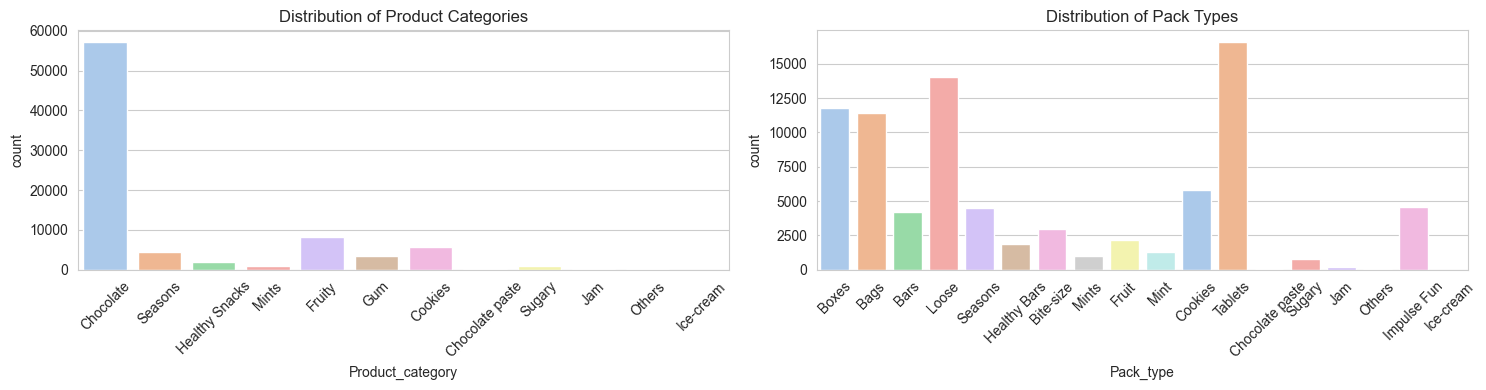

In [11]:
# Распределения значений в признаках 'Product_category', 'Pack_type' (функция расположена в файле functions.ipynb)
plot_target_columns(df_file_1)

У нас **два отдельных целевых признака (Product_category и Pack_type)** и мы хотим провести многоклассовую классификацию, тогда будем использовать оба этих признака в качестве целевых переменных. В случае, если нам не нужно их объединять в один.

Если мы хотите учитывать оба целевых признака при обучении модели и оценке её производительности, есть вариант:

**Multi-Output Classifier** (Мульти-выходной классификатор): Можно использовать классификатор, способный предсказывать несколько целевых переменных одновременно. В этом случае каждый целевой признак будет рассматриваться независимо друг от друга, и ваша модель будет обучаться на обоих целевых признаках одновременно. Примеры таких классификаторов в библиотеке scikit-learn: MultiOutputClassifier, MultiOutputRegressor.

У нас есть категориальные признаки с большим количеством уникальных значений и эти значения не имеют внутреннего порядка, тогда использование LabelEncoder может быть не самым эффективным подходом. Вместо этого, рекомендуется использовать метод кодирования, известный как "One-Hot Encoding" (одноразрядное кодирование). 

Но при его применении создается 28629 columns. Слишком большое количество столбцов может привести к проблеме известной как "проклятие размерности" (curse of dimensionality). Это может сказаться на производительности модели и привести к переобучению (overfitting). 

In [12]:
# Обучаемся и тестируемся на данных из df_file_1 
learning_first(df_file_1)

Accuracy: 0.633199759567221
Hamming Loss: 0.366800240432779
Jaccard Similarity Score (Jaccard Index): 0.46716848144371553
Precision: 0.7344603873225615
Recall: 0.633199759567221
F1 Score: 0.5926096694672028


1) Accuracy (Точность): 0.6332 - Эта метрика измеряет общую точность классификации и показывает долю правильно классифицированных образцов данных. Значение 0.6332 означает, что модель правильно классифицировала примерно 63.32% образцов.

2) Hamming Loss (Потери по Хэммингу): 0.3668 - Эта метрика представляет собой среднее значение доли неправильно предсказанных классов для каждого образца данных. Значение 0.3668 указывает на то, что в среднем около 36.68% элементов в целевых метках отличаются от предсказанных меток.

3) Jaccard Similarity Score (Jaccard Index) (Индекс Жаккара): 0.4672 - Это метрика, измеряющая сходство между двумя наборами данных. Значение 0.4672 означает, что средняя похожесть между предсказанными и истинными метками составляет около 46.72%.

4) Precision (Точность): 0.7345 - Эта метрика представляет собой долю правильно классифицированных положительных образцов из всех образцов, которые модель классифицировала как положительные. Значение 0.7345 указывает на высокую точность классификации положительных образцов.

5) Recall (Полнота): 0.6332 - Эта метрика показывает долю правильно классифицированных положительных образцов из всех истинных положительных образцов. Значение 0.6332 означает, что модель обнаруживает примерно 63.32% всех положительных образцов.

6) F1 Score: 0.5926 - Эта метрика представляет собой гармоническое среднее между точностью и полнотой. Значение 0.5926 указывает на сбалансированность между точностью и полнотой классификации.

Общий вывод: Модель, обученная на тренировочных данных, обладает средним качеством классификации, хотя некоторые метрики, такие как точность и полнота, достаточно высоки, другие, такие как потери по Хэммингу, требуют дальнейшего улучшения.

In [13]:
# Предобработка данных file_2 
df_file_2 = preprocessing_for_df(df_file_2).drop(['Product_category', 'Pack_type'], axis=1)

# В прогнозировании будут использоваться только те, которые есть и в df_file_1, и в df_file_2
for i in list(df_file_2.columns):
    list_with_new = list(set(df_file_2[i]) & set(df_file_1[i]))
    df_file_2 = df_file_2[df_file_2[i].isin(list_with_new)]

In [15]:
df_file_2

,manufacturer,brand,sku
sku_in_code,,,
17329831,SLICE OF JOY,SOJ,Батончик SOJ Rest Big Жареная Кукуруза 52г


На основании анализа тестового датасета мы обнаружили, что данные в нем значительно отличаются от данных в тренировочном датасете. После проведения сравнения мы выяснили, что существует только одна строка, которая присутствует и в тренировочном, и в тестовом датасетах. Это означает, что модель, обученная на тренировочных данных, не сможет корректно прогнозировать результаты на тестовом наборе данных из-за значительных различий в данных. Таким образом, на текущем этапе прогнозирование с использованием данного тестового датасета не является возможным.